# Data Analysis

In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing

We import the data from the pickle file as a JSON. This data corresponds with the 2015 ranked season of League of Legends.

In [7]:
data_json = pd.read_pickle('summoner_stats.pkl')
elos = pd.read_pickle('summoner_elos.pkl')
tags = pd.read_pickle('champion_tags.pkl')

## Dataframes generation

We will generate a raw dataframe containing the stadistics of the players for his preffered champion (we believe this is a better estimator than using the data for all the champions as they would not master some of them).

In [8]:
# Returns the data frame with each stadistic in a column and each player in a row.
def build_dataframes(json):
    pref_list = []
    for index in json:
        pref_dict = json[index]['pref_champ']['stats']
        pref_dict['summID'] = index
        pref_dict['champID'] = json[index]['pref_champ']['id']
        pref_list.append(pref_dict)
    df = pd.DataFrame(pref_list).set_index('summID')
    return df

# Adds a new column with the ELO of the player at the end of the season
def getElo(elos, data):
    list_league = []
    for index in data.index:
        values = elos[index]
        if values == '':
            league = np.nan
        else:
            league = values.split('_')[0]
        list_league.append(league)
    data['league'] = list_league      
    return data

# Adds the roles in which the champion can be played, e.g. Assasin/Support
def getChampionRole(roles, data):
    dict_champ = {}
    for i in roles['data']:
        dict_champ[roles['data'][i]['id']] = roles['data'][i]['tags']
    list_1st_rol, list_2n_rol = [], []
    for index in data.index:
        values = dict_champ[data.loc[index]['champID']]
        if len(values) == 1:
            rol_1st, rol_2nd = values*2
        else:
            rol_1st, rol_2nd  = values
        list_1st_rol.append(rol_1st)
        list_2n_rol.append(rol_2nd)
    data['champ1R'] = list_1st_rol
    data['champ2R'] = list_1st_rol       
    return data

In [9]:
df = build_dataframes(data_json)
df = getElo(elos, df)
df = getChampionRole(tags, df)

We check for NAN values:

In [10]:
df.isnull().sum()

champID                          0
maxChampionsKilled               0
maxNumDeaths                     0
mostChampionKillsPerSession      0
mostSpellsCast                   0
totalAssists                     0
totalChampionKills               0
totalDamageDealt                 0
totalDamageTaken                 0
totalDeathsPerSession            0
totalDoubleKills                 0
totalFirstBlood                  0
totalGoldEarned                  0
totalMagicDamageDealt            0
totalMinionKills                 0
totalPentaKills                  0
totalPhysicalDamageDealt         0
totalQuadraKills                 0
totalSessionsLost                0
totalSessionsPlayed              0
totalSessionsWon                 0
totalTripleKills                 0
totalTurretsKilled               0
totalUnrealKills                 0
league                         839
champ1R                          0
champ2R                          0
dtype: int64

The NAN values in League usually means that this players haven't played any ranked games. We drop them from the dataset:

In [11]:
df = df.dropna(axis = 0, subset = ['league'])

For the "League" an "Roles" string values we encode it using a LabelEncoder:

In [13]:
encoder_League = {'bronze' : 0,
                  'silver' : 1,
                  'gold' : 2,
                  'platinum' : 3,
                  'diamond' : 4,
                  'master' : 5 }
df['league'] = [encoder_League[league] for league in df.league]
encoTags = preprocessing.LabelEncoder()
encoTags.fit(df['champ1R'].unique())
print('League Encoder Classes: ', encoTags.classes_, 
      '\nCodification of Classes: ',   encoTags.transform( encoTags.classes_))
df['champ1R'] = encoTags.transform(df['champ1R'])
df['champ2R'] = encoTags.transform(df['champ2R'])

League Encoder Classes:  ['Assassin' 'Fighter' 'Mage' 'Marksman' 'Support' 'Tank'] 
Codification of Classes:  [0 1 2 3 4 5]


We inspect the columns for the 'Preferred champion" dataframe. We also set the "Summoner ID" as the index. 

In [14]:
print(df.columns)
df.head()

Index(['champID', 'maxChampionsKilled', 'maxNumDeaths',
       'mostChampionKillsPerSession', 'mostSpellsCast', 'totalAssists',
       'totalChampionKills', 'totalDamageDealt', 'totalDamageTaken',
       'totalDeathsPerSession', 'totalDoubleKills', 'totalFirstBlood',
       'totalGoldEarned', 'totalMagicDamageDealt', 'totalMinionKills',
       'totalPentaKills', 'totalPhysicalDamageDealt', 'totalQuadraKills',
       'totalSessionsLost', 'totalSessionsPlayed', 'totalSessionsWon',
       'totalTripleKills', 'totalTurretsKilled', 'totalUnrealKills', 'league',
       'champ1R', 'champ2R'],
      dtype='object')


,champID,maxChampionsKilled,maxNumDeaths,mostChampionKillsPerSession,mostSpellsCast,totalAssists,totalChampionKills,totalDamageDealt,totalDamageTaken,totalDeathsPerSession,...,totalQuadraKills,totalSessionsLost,totalSessionsPlayed,totalSessionsWon,totalTripleKills,totalTurretsKilled,totalUnrealKills,league,champ1R,champ2R
summID,,,,,,,,,,,,,,,,,,,,,
21093322,111,10,13,10,0,1003,156,4345111,1949035,473,...,0,30,72,42,0,33,0,4,5,5
22668791,18,22,9,22,0,136,184,4087735,446447,90,...,2,9,21,12,5,57,0,2,3,3
25280947,103,18,11,18,0,414,389,6886381,917304,257,...,2,17,48,31,6,41,0,4,2,2
39400054,412,5,13,5,0,696,80,1155605,854706,227,...,0,20,40,20,0,13,0,3,4,4
23085875,106,20,13,20,0,477,270,4574284,1497220,258,...,0,17,39,22,0,32,0,1,1,1


We reorder the columns and drop some of them like the 0 value stats (deprecated data from the Riot API) and unrelevant data ('unreal kills', 'games against IA', etc..)

In [15]:
df = df[['champID', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 
               'totalMinionKills', 'totalTurretsKilled', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt', 
               'totalDamageTaken', 'totalDeathsPerSession', 'maxNumDeaths', 'totalAssists', 'totalChampionKills', 'totalDoubleKills', 
               'totalTripleKills', 'totalQuadraKills', 'totalPentaKills', 'mostChampionKillsPerSession', 'league', 'champ1R', 'champ2R']]
print(df.dtypes)
df.head()

champID                        int64
totalSessionsPlayed            int64
totalSessionsWon               int64
totalSessionsLost              int64
totalGoldEarned                int64
totalMinionKills               int64
totalTurretsKilled             int64
totalPhysicalDamageDealt       int64
totalMagicDamageDealt          int64
totalDamageTaken               int64
totalDeathsPerSession          int64
maxNumDeaths                   int64
totalAssists                   int64
totalChampionKills             int64
totalDoubleKills               int64
totalTripleKills               int64
totalQuadraKills               int64
totalPentaKills                int64
mostChampionKillsPerSession    int64
league                         int64
champ1R                        int64
champ2R                        int64
dtype: object


,champID,totalSessionsPlayed,totalSessionsWon,totalSessionsLost,totalGoldEarned,totalMinionKills,totalTurretsKilled,totalPhysicalDamageDealt,totalMagicDamageDealt,totalDamageTaken,...,totalAssists,totalChampionKills,totalDoubleKills,totalTripleKills,totalQuadraKills,totalPentaKills,mostChampionKillsPerSession,league,champ1R,champ2R
summID,,,,,,,,,,,,,,,,,,,,,
21093322,111,72,42,30,691896,4038,33,1062719,2760062,1949035,...,1003,156,8,0,0,0,10,4,5,5
22668791,18,21,12,9,288278,4519,57,3348818,713899,446447,...,136,184,23,5,2,0,22,2,3,3
25280947,103,48,31,17,594289,9402,41,820233,4119536,917304,...,414,389,48,6,2,0,18,4,2,2
39400054,412,40,20,20,391698,1089,13,320137,831710,854706,...,696,80,2,0,0,0,5,3,4,4
23085875,106,39,22,17,452716,2042,32,1849688,2291764,1497220,...,477,270,18,0,0,0,20,1,1,1


## Data filtering and standarization by sessions played

We only consider the accounts that have 50 or more games played. 

In [16]:
df = df[df.totalSessionsPlayed >= 50]

The "total" stadisitics are calculated as the sum of the totalSessionsPlayed so we must calculate the average data for all games.

In [17]:
def calculateAvg(df):
    df['GoldEarned'] = df['totalGoldEarned'] / df['totalSessionsPlayed']
    df['MinionKills'] = df['totalMinionKills'] / df['totalSessionsPlayed']             
    df['PhysicalDamageDealt'] = df['totalPhysicalDamageDealt'] / df['totalSessionsPlayed']     
    df['MagicDamageDealt'] = df['totalMagicDamageDealt'] / df['totalSessionsPlayed']  
    df['DamageTaken'] = df['totalDamageTaken'] / df['totalSessionsPlayed']              
    df['DoubleKills'] = df['totalDoubleKills'] / df['totalSessionsPlayed']
    df['TripleKills'] = df['totalTripleKills'] / df['totalSessionsPlayed']
    df['QuadraKills'] = df['totalQuadraKills'] / df['totalSessionsPlayed']
    df['PentaKills'] = df['totalPentaKills'] / df['totalSessionsPlayed']
    df['TurretsKilled'] = df['totalTurretsKilled'] / df['totalSessionsPlayed']
    return df

In [18]:
df = calculateAvg(df)

### KDA calculation

One important metric in competitive games as League of Legends is the KDA (Kills-Deaths-Assists) ratio. For a given player when can calculate the KDA for the ranked Season 5 as 
\begin{equation}
KDA = \frac{totalChampionKills + totalAssists}{totalDeathsPerSession} 
\end{equation}

In [19]:
df['KDA'] = (df['totalChampionKills'] + df['totalAssists']) / df['totalDeathsPerSession']

In [20]:
df[['KDA', 'totalChampionKills', 'totalAssists', 'totalDeathsPerSession']].head()

,KDA,totalChampionKills,totalAssists,totalDeathsPerSession
summID,,,,
21093322,2.450317,156,1003,473
65475539,2.747475,421,395,297
40061670,2.352941,371,389,323
42962372,2.476454,350,544,361
54320136,2.364243,434,3110,1499


### Win rate calculation

We calculate the Win Rate percentage per player for both dataframes (it will be the same as they are the same players).

In [21]:
df['WinRate'] = df['totalSessionsWon'] / df['totalSessionsPlayed']

In [22]:
df[['WinRate', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost']].head()

,WinRate,totalSessionsPlayed,totalSessionsWon,totalSessionsLost
summID,,,,
21093322,0.583333,72,42,30
65475539,0.500000,56,28,28
40061670,0.547170,53,29,24
42962372,0.666667,57,38,19
54320136,0.517949,195,101,94


### Drop the unnecessary data

In [23]:
df.drop(df[['totalChampionKills', 'totalTurretsKilled', 'totalAssists', 'totalDeathsPerSession', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 'totalMinionKills', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt','totalDamageTaken', 'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills', 'totalPentaKills']], axis=1, inplace=True)

## Dataframe description 

In [24]:
df.head()

,champID,maxNumDeaths,mostChampionKillsPerSession,league,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
summID,,,,,,,,,,,,,,,,,,
21093322,111,13,10,4,5,5,9609.666667,56.083333,14759.986111,38334.194444,27069.930556,0.111111,0.000000,0.000000,0.0,0.458333,2.450317,0.583333
65475539,67,15,30,4,3,3,12144.750000,184.267857,116148.517857,7592.785714,21315.803571,1.071429,0.178571,0.035714,0.0,1.321429,2.747475,0.500000
40061670,64,12,19,0,1,1,12182.226415,156.943396,113092.075472,36064.226415,28666.981132,0.490566,0.000000,0.000000,0.0,1.452830,2.352941,0.547170
42962372,150,14,15,3,1,1,12042.543860,174.368421,117170.210526,24455.631579,32259.087719,0.526316,0.070175,0.017544,0.0,1.105263,2.476454,0.666667
54320136,412,16,12,0,4,4,9112.015385,23.958974,6169.928205,20835.610256,24339.200000,0.082051,0.005128,0.000000,0.0,0.210256,2.364243,0.517949


### Data description

In [25]:
df.describe()

,champID,maxNumDeaths,mostChampionKillsPerSession,league,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
count,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000,19376.000000
mean,123.067816,14.917011,21.008516,2.237923,2.256555,2.256555,12273.157339,130.469778,84843.377094,42483.932835,24929.761000,0.779273,0.118861,0.017843,0.003084,1.082585,2.836521,0.552588
std,112.174579,3.101571,7.739186,1.354470,1.503641,1.503641,1543.327483,69.701434,64992.968552,45235.406097,5832.858027,0.492057,0.110788,0.025195,0.007283,0.628147,0.745607,0.063363
min,1.000000,6.000000,2.000000,0.000000,0.000000,0.000000,6060.000000,4.178571,1669.872814,32.338235,3261.898396,0.000000,0.000000,0.000000,0.000000,0.018519,0.742905,0.096154
25%,53.000000,13.000000,17.000000,1.000000,1.000000,1.000000,11529.530749,55.401178,15997.206801,9772.550694,20689.609463,0.418114,0.030675,0.000000,0.000000,0.545455,2.333052,0.513369
50%,89.000000,15.000000,22.000000,3.000000,2.000000,2.000000,12617.229146,151.064097,92345.091315,22407.741368,24041.579754,0.790824,0.097561,0.009804,0.000000,1.013699,2.727886,0.553846
75%,157.000000,17.000000,26.000000,3.000000,3.000000,3.000000,13344.580723,192.073776,142268.676688,63246.810278,28622.164394,1.107692,0.176991,0.026549,0.000000,1.537436,3.204089,0.592593
max,432.000000,47.000000,57.000000,5.000000,5.000000,5.000000,20201.985507,272.441176,267872.785714,230219.826923,52609.887500,4.086957,1.260870,0.405797,0.144928,3.586207,9.892157,0.923077


### Covariances and Correlation between features

In [26]:
df.cov()

,champID,maxNumDeaths,mostChampionKillsPerSession,league,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
champID,1.258314e+04,-23.416668,-244.091210,13.574574,36.022497,36.022497,-5.158257e+04,-1.427460e+03,-3.649911e+05,-1.194163e+06,-7.676868e+04,-10.513886,-1.484462,-0.170858,-0.021694,-8.937308,6.196363,-0.620947
maxNumDeaths,-2.341667e+01,9.619745,9.364268,-1.690138,-0.797856,-0.797856,9.076633e+02,8.093286e+00,2.529479e+04,-1.786468e+03,3.820353e+03,0.413704,0.071527,0.011437,0.002028,0.281127,-1.434421,-0.033542
mostChampionKillsPerSession,-2.440912e+02,9.364268,59.894998,-2.087910,-5.954804,-5.954804,9.204217e+03,3.005625e+02,2.593683e+05,2.879763e+04,2.053117e+03,3.086810,0.566528,0.095875,0.018049,2.655313,-1.927735,0.025266
league,1.357457e+01,-1.690138,-2.087910,1.834590,-0.078850,-0.078850,-1.247302e+02,9.229713e+00,1.321591e+03,-1.273805e+02,-1.022882e+03,-0.058107,-0.004433,0.000233,0.000238,-0.049103,0.236631,0.018571
champ1R,3.602250e+01,-0.797856,-5.954804,-0.078850,2.260938,2.260938,-1.065883e+03,-2.154760e+01,-2.833746e+04,-9.591857e+03,-2.078674e+03,-0.298903,-0.048036,-0.006535,-0.001031,-0.169826,0.295864,-0.002749
champ2R,3.602250e+01,-0.797856,-5.954804,-0.078850,2.260938,2.260938,-1.065883e+03,-2.154760e+01,-2.833746e+04,-9.591857e+03,-2.078674e+03,-0.298903,-0.048036,-0.006535,-0.001031,-0.169826,0.295864,-0.002749
GoldEarned,-5.158257e+04,907.663312,9204.216843,-124.730238,-1065.882881,-1065.882881,2.381860e+06,7.934453e+04,6.808892e+07,8.200006e+06,6.613057e+05,614.922270,114.584048,19.620061,3.640688,685.483313,-251.355586,19.157017
MinionKills,-1.427460e+03,8.093286,300.562465,9.229713,-21.547601,-21.547601,7.934453e+04,4.858290e+03,2.620401e+06,2.452569e+05,-9.104266e+04,21.973036,4.331292,0.759053,0.142469,33.189496,-11.803711,0.515184
PhysicalDamageDealt,-3.649911e+05,25294.790282,259368.271924,1321.591148,-28337.464246,-28337.464246,6.808892e+07,2.620401e+06,4.224086e+09,-1.717356e+09,3.506909e+07,18989.175732,3769.496059,693.112989,130.325806,31306.709589,-14133.887786,57.177405
MagicDamageDealt,-1.194163e+06,-1786.468489,28797.627135,-127.380538,-9591.857485,-9591.857485,8.200006e+06,2.452569e+05,-1.717356e+09,2.046242e+09,-1.207461e+07,-306.796373,-328.882499,-111.275328,-23.527755,-6320.786506,3099.665712,388.835285


In [27]:
df.corr()

,champID,maxNumDeaths,mostChampionKillsPerSession,league,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
champID,1.000000,-0.067305,-0.281166,0.089343,0.213567,0.213567,-0.297955,-0.182569,-0.050064,-0.235337,-0.117330,-0.190482,-0.119449,-0.060455,-0.026555,-0.126838,0.074085,-0.087363
maxNumDeaths,-0.067305,1.000000,0.390119,-0.402319,-0.171080,-0.171080,0.189620,0.037437,0.125482,-0.012733,0.211174,0.271077,0.208159,0.146354,0.089784,0.144298,-0.620275,-0.170676
mostChampionKillsPerSession,-0.281166,0.390119,1.000000,-0.199181,-0.511715,-0.511715,0.770608,0.557183,0.515650,0.082259,0.045482,0.810586,0.660744,0.491697,0.320237,0.546209,-0.334073,0.051523
league,0.089343,-0.402319,-0.199181,1.000000,-0.038716,-0.038716,-0.059668,0.097764,0.015013,-0.002079,-0.129472,-0.087185,-0.029543,0.006820,0.024116,-0.057714,0.234311,0.216387
champ1R,0.213567,-0.171080,-0.511715,-0.038716,1.000000,1.000000,-0.459311,-0.205595,-0.289968,-0.141020,-0.237007,-0.403990,-0.288358,-0.172510,-0.094137,-0.179803,0.263899,-0.028849
champ2R,0.213567,-0.171080,-0.511715,-0.038716,1.000000,1.000000,-0.459311,-0.205595,-0.289968,-0.141020,-0.237007,-0.403990,-0.288358,-0.172510,-0.094137,-0.179803,0.263899,-0.028849
GoldEarned,-0.297955,0.189620,0.770608,-0.059668,-0.459311,-0.459311,1.000000,0.737594,0.678816,0.117457,0.073462,0.809742,0.670152,0.504581,0.323920,0.707094,-0.218434,0.195900
MinionKills,-0.182569,0.037437,0.557183,0.097764,-0.205595,-0.205595,0.737594,1.000000,0.578442,0.077786,-0.223935,0.640668,0.560897,0.432235,0.280666,0.758049,-0.227126,0.116650
PhysicalDamageDealt,-0.050064,0.125482,0.515650,0.015013,-0.289968,-0.289968,0.678816,0.578442,1.000000,-0.584138,0.092507,0.593778,0.523509,0.423279,0.275344,0.766849,-0.291665,0.013884
MagicDamageDealt,-0.235337,-0.012733,0.082259,-0.002079,-0.141020,-0.141020,0.117457,0.077786,-0.584138,1.000000,-0.045763,-0.013783,-0.065625,-0.097636,-0.071419,-0.222449,0.091902,0.135660


## Data visualization 

In [28]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

We visualize the most important stadistics. This will help us to understand how the features could ditributed and how good is the data that we have.

### KDA per champion

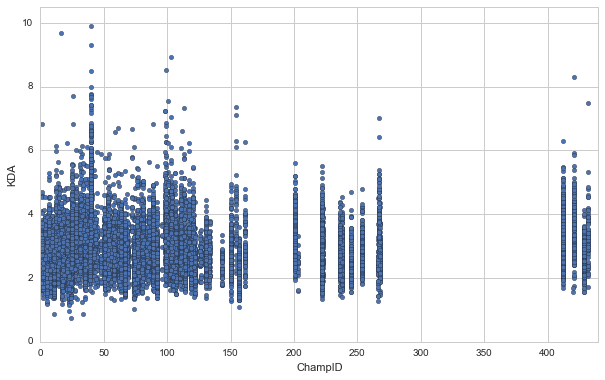

In [29]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champID'], df['KDA'])
plt.xlabel('ChampID')
plt.ylabel('KDA')
plt.xlim(0, 440)
plt.ylim(0, 10.5)
plt.show()

### Winrate percentage per champion

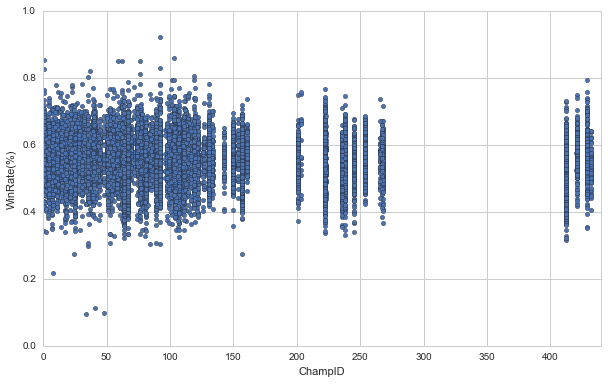

In [30]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champID'], df['WinRate'])
plt.xlabel('ChampID')
plt.ylabel('WinRate(%)')
plt.xlim(0, 440)
plt.ylim(0, 1)
plt.show()

### Average Gold Earned per champion 

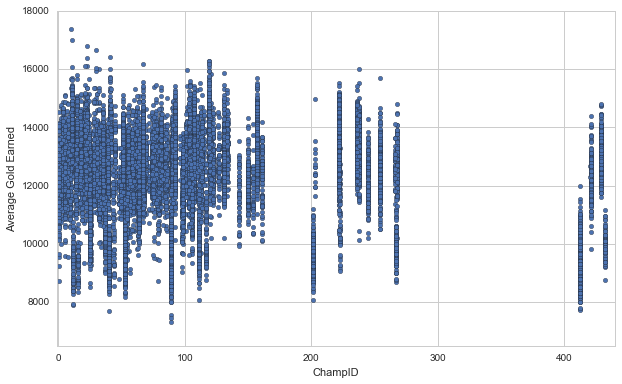

In [31]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champID'], df['GoldEarned'])
plt.xlabel('ChampID')
plt.ylabel('Average Gold Earned')
plt.xlim(-1, 440)
plt.ylim(6500, 18000)
plt.show()

### Average Creep Score (CS) per champion

The creep score is the total minions killed in a game.

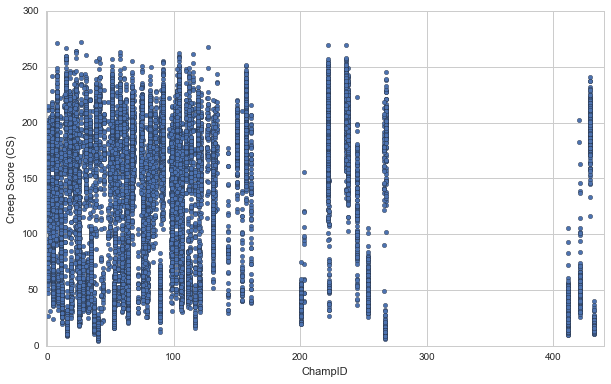

In [32]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champID'], df['MinionKills'])
plt.xlabel('ChampID')
plt.ylabel('Creep Score (CS)')
plt.xlim(-1, 440)
plt.ylim(-0.05, 300)
plt.show()

### Damage dealt by champion

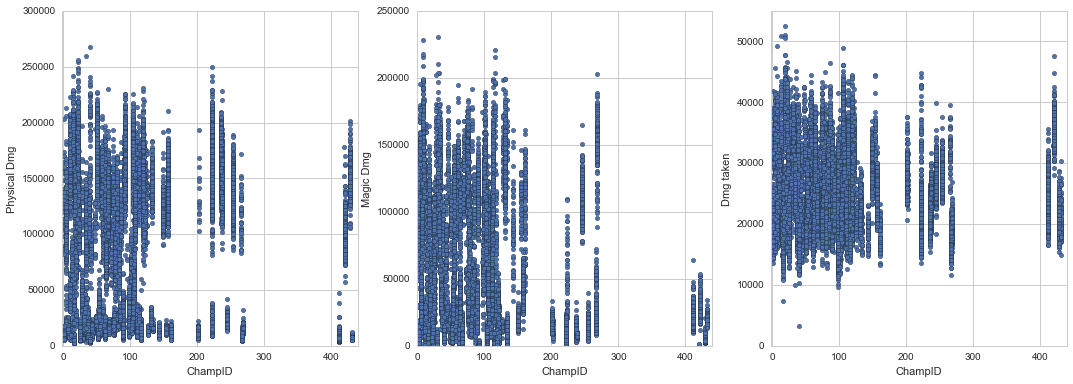

In [33]:
fig = plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df['champID'], df['PhysicalDamageDealt'])
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df['champID'], df['MagicDamageDealt'])
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df['champID'], df['DamageTaken'])
ax1.set_xlim([-1, 440])
ax1.set_ylim([0, 300000])
ax1.set_xlabel('ChampID')
ax1.set_ylabel('Physical Dmg')
ax2.set_xlim([-1, 440])
ax2.set_ylim([0, 250000])
ax2.set_xlabel('ChampID')
ax2.set_ylabel('Magic Dmg')
ax3.set_xlim([-1, 440])
ax3.set_ylim([0, 55000])
ax3.set_xlabel('ChampID')
ax3.set_ylabel('Dmg taken')
plt.show()

### Kills and Multikills per champion

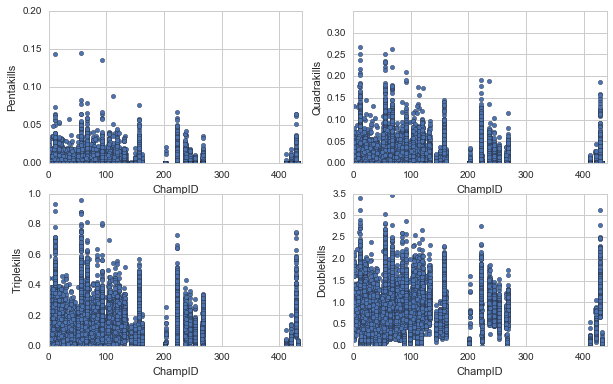

In [34]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(df['champID'], df['PentaKills'])
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(df['champID'], df['QuadraKills'])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(df['champID'], df['TripleKills'])
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(df['champID'], df['DoubleKills'])
ax1.set_xlim([-0.5, 440])
ax1.set_ylim([0, 0.2])
ax1.set_xlabel('ChampID')
ax1.set_ylabel('Pentakills')
ax2.set_xlim([-0.5, 440])
ax2.set_ylim([0, 0.35])
ax2.set_xlabel('ChampID')
ax2.set_ylabel('Quadrakills')
ax3.set_xlim([-0.5, 440])
ax3.set_ylim([0, 1])
ax3.set_xlabel('ChampID')
ax3.set_ylabel('Triplekills')
ax4.set_xlim([-0.5, 440])
ax4.set_ylim([0, 3.5])
ax4.set_xlabel('ChampID')
ax4.set_ylabel('Doublekills')
plt.show()

### Scatter matrix for all the stadistics

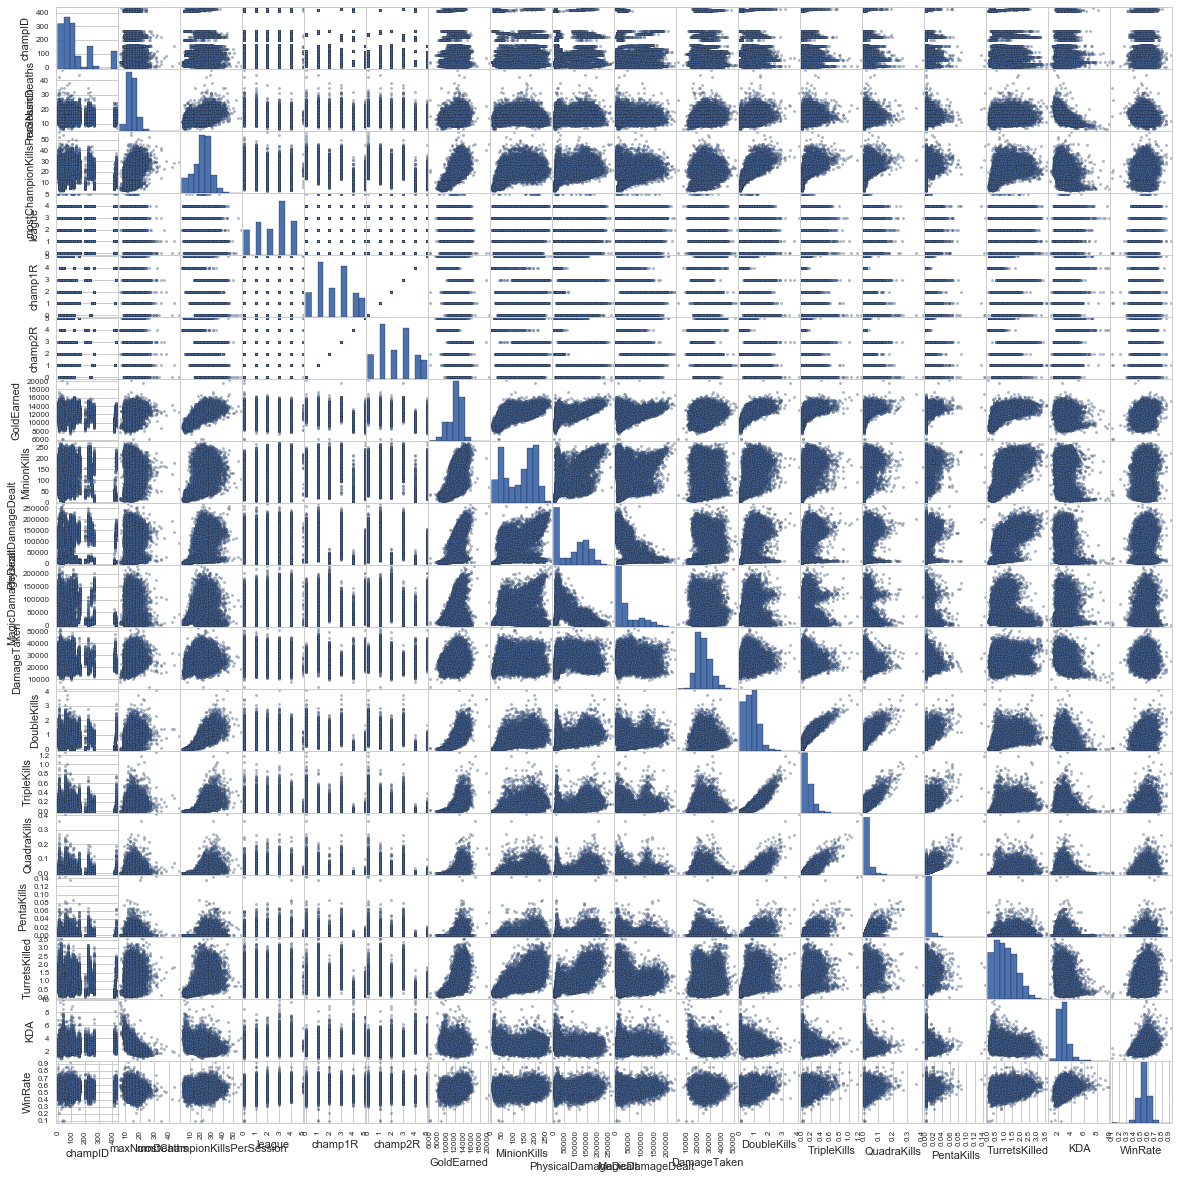

In [35]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, figsize = (20,20))
plt.show()

## Data visualization by elo

We visualize each stadistic by elo. Rebember the elo encoding:

* 'Bronze': 0 
* 'Silver': 1
* 'Gold': 2 
* 'Diamond': 3 
* 'Platinum': 4 
* 'Diamond': 5

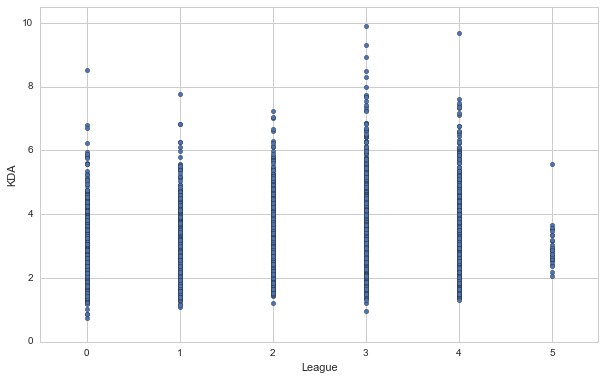

In [37]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['league'], df['KDA'])
plt.xlabel('League')
plt.ylabel('KDA')
plt.xlim(-0.5, 5.5)
plt.ylim(0, 10.5)
plt.show()

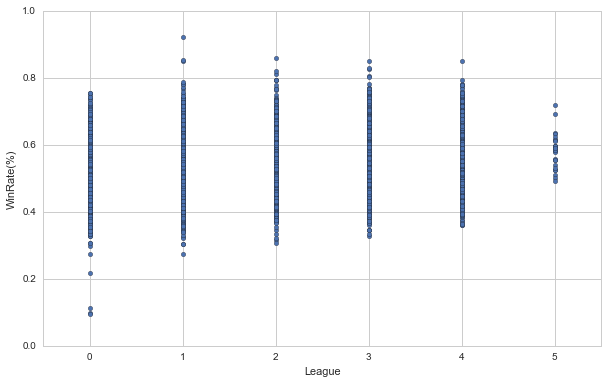

In [39]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['league'], df['WinRate'])
plt.xlabel('League')
plt.ylabel('WinRate(%)')
plt.xlim(-0.5,5.5)
plt.ylim(0, 1)
plt.show()

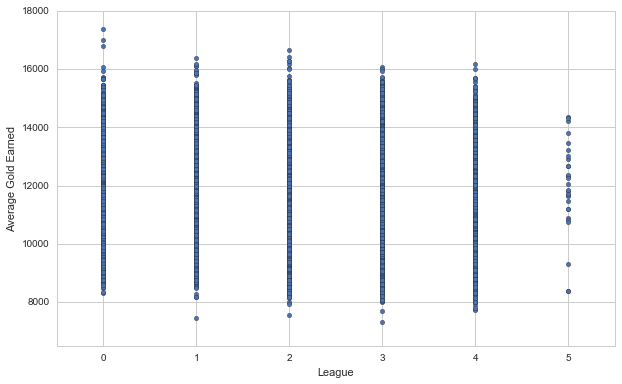

In [40]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['league'], df['GoldEarned'])
plt.xlabel('League')
plt.ylabel('Average Gold Earned')
plt.xlim(-0.5,5.5)
plt.ylim(6500, 18000)
plt.show()

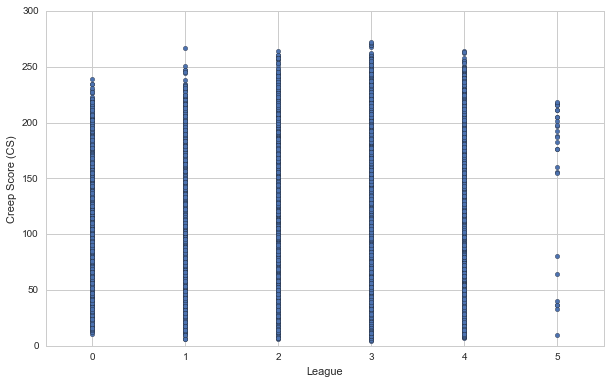

In [41]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['league'], df['MinionKills'])
plt.xlabel('League')
plt.ylabel('Creep Score (CS)')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.05, 300)
plt.show()

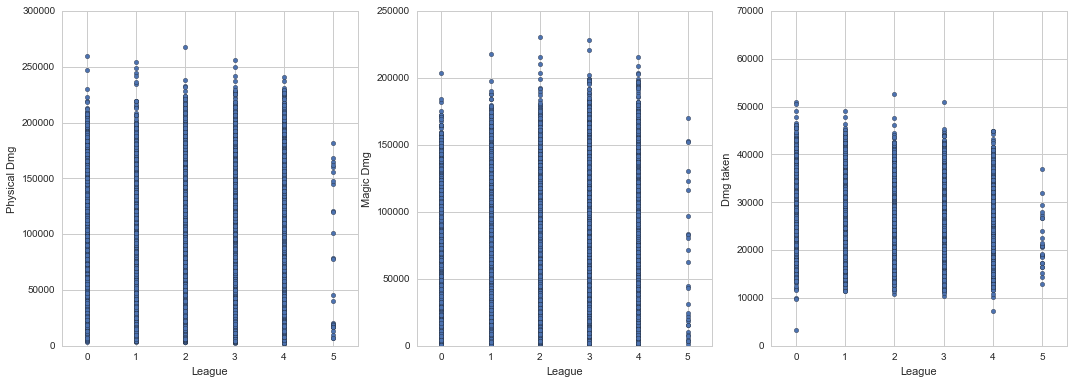

In [43]:
fig = plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df['league'], df['PhysicalDamageDealt'])
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df['league'], df['MagicDamageDealt'])
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df['league'], df['DamageTaken'])
ax1.set_xlim([-0.5, 5.5])
ax1.set_ylim([0, 300000])
ax1.set_xlabel('League')
ax1.set_ylabel('Physical Dmg')
ax2.set_xlim([-0.5, 5.5])
ax2.set_ylim([0, 250000])
ax2.set_xlabel('League')
ax2.set_ylabel('Magic Dmg')
ax3.set_xlim([-0.5, 5.5])
ax3.set_ylim([0, 70000])
ax3.set_xlabel('League')
ax3.set_ylabel('Dmg taken')
plt.show()

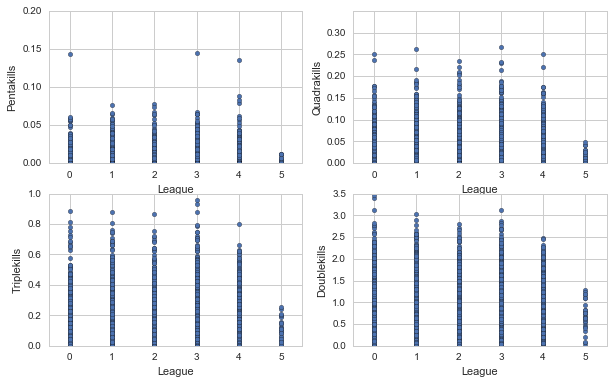

In [44]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(df['league'], df['PentaKills'])
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(df['league'], df['QuadraKills'])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(df['league'], df['TripleKills'])
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(df['league'], df['DoubleKills'])
ax1.set_xlim([-0.5, 5.5])
ax1.set_ylim([0, 0.2])
ax1.set_xlabel('League')
ax1.set_ylabel('Pentakills')
ax2.set_xlim([-0.5, 5.5])
ax2.set_ylim([0, 0.35])
ax2.set_xlabel('League')
ax2.set_ylabel('Quadrakills')
ax3.set_xlim([-0.5, 5.5])
ax3.set_ylim([0, 1])
ax3.set_xlabel('League')
ax3.set_ylabel('Triplekills')
ax4.set_xlim([-0.5, 5.5])
ax4.set_ylim([0, 3.5])
ax4.set_xlabel('League')
ax4.set_ylabel('Doublekills')
plt.show()

We can see that there is not much difference in stadistics between leagues. Classification is not going to be an easy task since each league can't just be ranked by raw performances. The range and density of values is the same for each elo. 

## Data visualization by role

Now we visualize the data for each role. Remember the label encoding: 
* 'Assassin': 0 
* 'Fighter': 1
* 'Mage': 2 
* 'Marksman': 3 
* 'Support': 4 
* 'Tank': 5

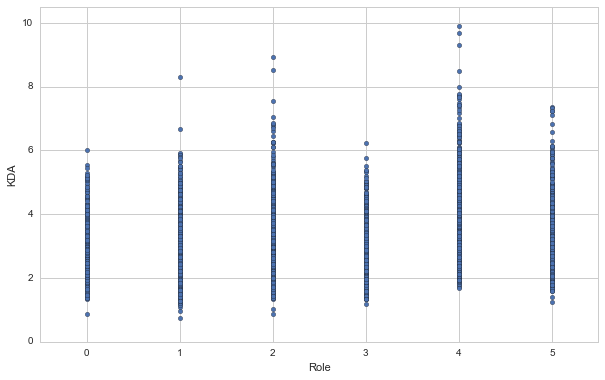

In [30]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champ1R'], df['KDA'])
plt.xlabel('Role')
plt.ylabel('KDA')
plt.xlim(-0.5, 5.5)
plt.ylim(0, 10.5)
plt.show()

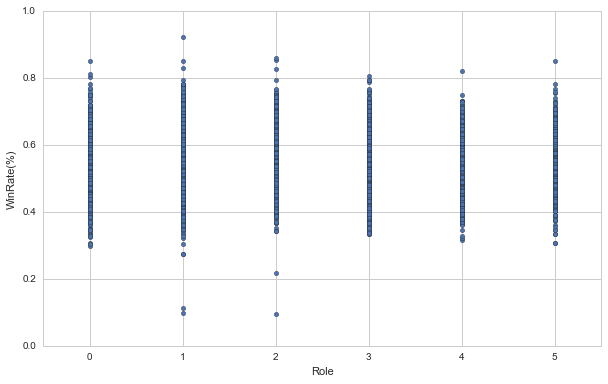

In [31]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champ1R'], df['WinRate'])
plt.xlabel('Role')
plt.ylabel('WinRate(%)')
plt.xlim(-0.5,5.5)
plt.ylim(0, 1)
plt.show()

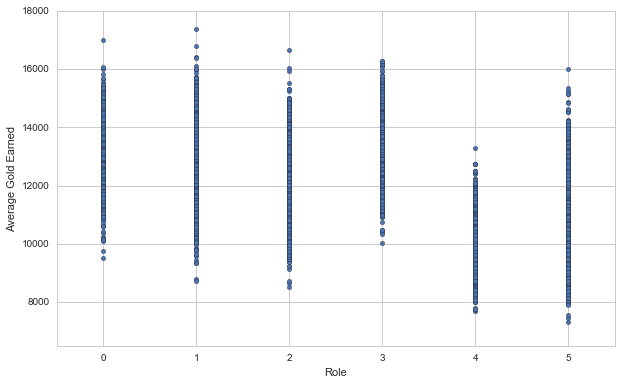

In [32]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champ1R'], df['GoldEarned'])
plt.xlabel('Role')
plt.ylabel('Average Gold Earned')
plt.xlim(-0.5,5.5)
plt.ylim(6500, 18000)
plt.show()

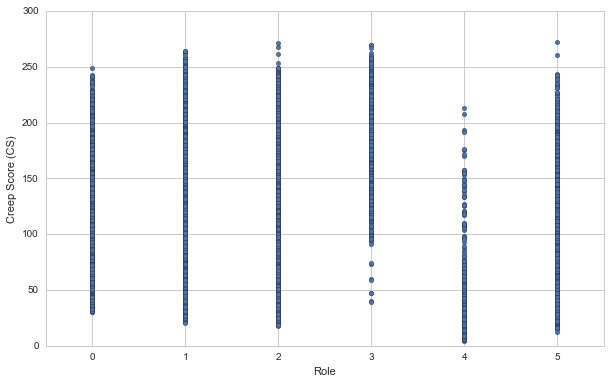

In [33]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df['champ1R'], df['MinionKills'])
plt.xlabel('Role')
plt.ylabel('Creep Score (CS)')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.05, 300)
plt.show()

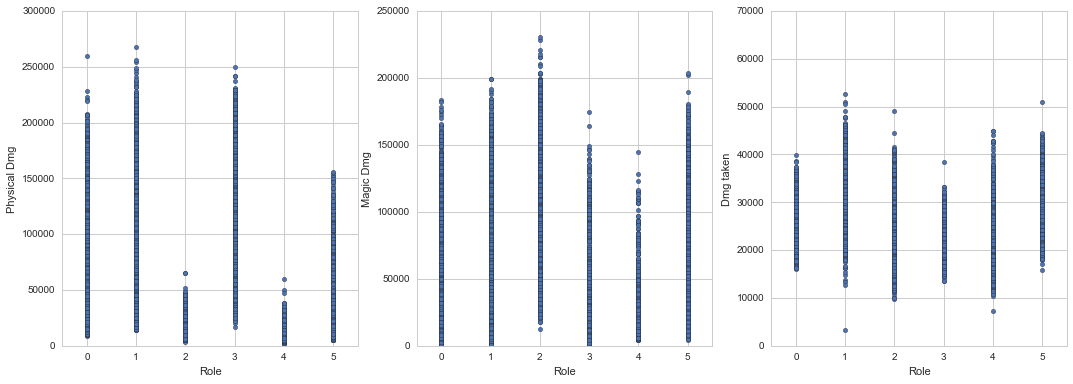

In [34]:
fig = plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df['champ1R'], df['PhysicalDamageDealt'])
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df['champ1R'], df['MagicDamageDealt'])
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df['champ1R'], df['DamageTaken'])
ax1.set_xlim([-0.5, 5.5])
ax1.set_ylim([0, 300000])
ax1.set_xlabel('Role')
ax1.set_ylabel('Physical Dmg')
ax2.set_xlim([-0.5, 5.5])
ax2.set_ylim([0, 250000])
ax2.set_xlabel('Role')
ax2.set_ylabel('Magic Dmg')
ax3.set_xlim([-0.5, 5.5])
ax3.set_ylim([0, 70000])
ax3.set_xlabel('Role')
ax3.set_ylabel('Dmg taken')
plt.show()

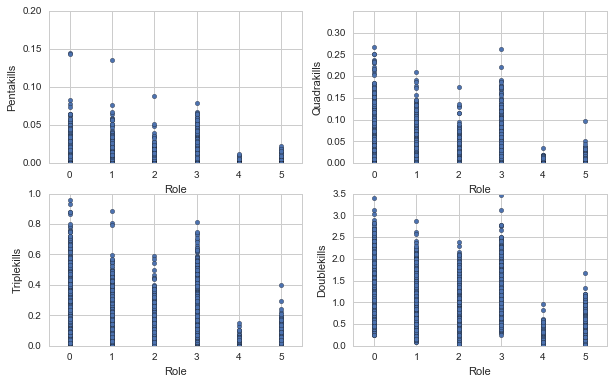

In [35]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(df['champ1R'], df['PentaKills'])
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(df['champ1R'], df['QuadraKills'])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(df['champ1R'], df['TripleKills'])
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(df['champ1R'], df['DoubleKills'])
ax1.set_xlim([-0.5, 5.5])
ax1.set_ylim([0, 0.2])
ax1.set_xlabel('Role')
ax1.set_ylabel('Pentakills')
ax2.set_xlim([-0.5, 5.5])
ax2.set_ylim([0, 0.35])
ax2.set_xlabel('Role')
ax2.set_ylabel('Quadrakills')
ax3.set_xlim([-0.5, 5.5])
ax3.set_ylim([0, 1])
ax3.set_xlabel('Role')
ax3.set_ylabel('Triplekills')
ax4.set_xlim([-0.5, 5.5])
ax4.set_ylim([0, 3.5])
ax4.set_xlabel('Role')
ax4.set_ylabel('Doublekills')
plt.show()

Each role has a specific purpose in the game, e.g assasins deal damage, tanks receive damage, supports don't kill and only assist, etc...

It is hard to classify how well a player is doing only based in the role and the raw stadistics. We should take into account the role of the champion played what purpose does that role have, establishing combinations of features. This is not an easy task as the combinations could be unlimited, so for the scope of this project we will keep the influence of the roles outside of the model. 

A future work could be to engineer these feature combinations for each role and train a particular model for each role, predicting the league based in the performance in that role. 

### 3d visualization of the gold earned, physical damage and league  by champion

In [52]:
import plotly.plotly as py
import plotly.graph_objs as go

py.sign_in('juanluismoralperez', 'MUMjWF4QwNy8AtZW6WUq')

trace1 = go.Scatter3d(
    x=df.PhysicalDamageDealt,
    y=df.GoldEarned,
    z=df.league,
    mode='markers',
    marker=dict(
        size=12,
        color=df.champ1R,               
        colorscale='Viridis',   
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~juanluismoralperez/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


When taking into account combination of stadistics, the data is clusterized as we can observe in the 3D figure above. We will use this idea to train the model using combinations of the most important features.

## Export the processed data

In [46]:
df.to_pickle('pc_processed.pkl')

## Processing the 2016 season data

For the final result we will train with the 2015 season data and we will predict the 2015 data

In [58]:
data_json = pd.read_pickle('summoner_stats_2016.pkl')
elos = pd.read_pickle('summoner_elos_2016.pkl')

df = build_dataframes(data_json)
df = getElo(elos, df)
df = getChampionRole(tags, df)

In [59]:
df = df.dropna(axis = 0, subset = ['league'])
encoder_League = {'bronze' : 0,
                  'silver' : 1,
                  'gold' : 2,
                  'platinum' : 3,
                  'diamond' : 4,
                  'master' : 5 }
df['league'] = [encoder_League[league] for league in df.league]
encoTags = preprocessing.LabelEncoder()
encoTags.fit(df['champ1R'].unique())
print('League Encoder Classes: ', encoTags.classes_, 
      '\nCodification of Classes: ',   encoTags.transform( encoTags.classes_))
df['champ1R'] = encoTags.transform(df['champ1R'])
df['champ2R'] = encoTags.transform(df['champ2R'])

League Encoder Classes:  ['Assassin' 'Fighter' 'Mage' 'Marksman' 'Support' 'Tank'] 
Codification of Classes:  [0 1 2 3 4 5]


In [60]:
df = df[['champID', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 
               'totalMinionKills', 'totalTurretsKilled', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt', 
               'totalDamageTaken', 'totalDeathsPerSession', 'maxNumDeaths', 'totalAssists', 'totalChampionKills', 'totalDoubleKills', 
               'totalTripleKills', 'totalQuadraKills', 'totalPentaKills', 'mostChampionKillsPerSession', 'league', 'champ1R', 'champ2R']]

In [61]:
df = calculateAvg(df)
df['KDA'] = (df['totalChampionKills'] + df['totalAssists']) / df['totalDeathsPerSession']
df['WinRate'] = df['totalSessionsWon'] / df['totalSessionsPlayed']
df.drop(df[['totalChampionKills', 'totalTurretsKilled', 'totalAssists', 'totalDeathsPerSession', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 'totalMinionKills', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt','totalDamageTaken', 'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills', 'totalPentaKills']], axis=1, inplace=True)

In [62]:
df.to_pickle('pc_processed_2016.pkl')